<a href="https://colab.research.google.com/github/Arpitkamal/DL-106---Optimization-Algorithms/blob/master/OverfittingandRegularisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Outline



1.   L2 norm and loading datasets
2.   Modifying our FF class
3.   Use more complex models to reduce bias
4.   Demonstate overfitting for very large models
5.   Use L2 regularisation for preventing overfitting
6.   Use moise on training data for preventing overfitting





# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_iris

from numpy.linalg import norm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["red","yellow","green"])

In [0]:
np.random.seed(0)

# Generate data

In [0]:
iris = load_iris()
data = iris.data[:, :2] # take only the first two features
labels = iris.target

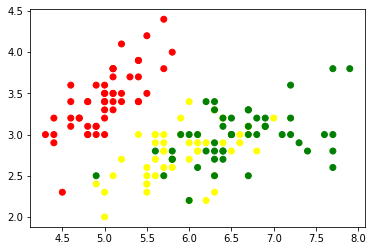

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [6]:
print("Data shape", data.shape)
print("Labels shape", labels.shape)

Data shape (150, 2)
Labels shape (150,)


# Mutli class clasification 

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0, test_size=0.2)
print(X_train.shape, X_val.shape, labels.shape)

(120, 2) (30, 2) (150,)


In [8]:
enc = OneHotEncoder()
# 0 -> (1,0,0,0), 1 -> (0,1,0,0), 2 -> (0,0,1,0), 3 -> (0,0,0,1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(120, 3) (30, 3)


# FF Class

In [0]:
class FFNetwork:

  def __init__(self, num_hidden=2 , init_method = 'xavier', activation_function = 'sigmoid', leaky_slope = 0.1):

    self.params={}
    self.num_layers = 2
    self.layer_sizes = [2, num_hidden, 3]
    self.activation_function = activation_function
    self.leaky_slope = leaky_slope
    np.random.seed(0)

    if init_method == "random":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i])
        self.params["B"+str(i)] = np.random.randn(1, self.layer_sizes[i])

    elif init_method == "he":
      for i in range(1, self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i])*np.sqrt(2/self.layer_sizes[i-1])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])

    elif init_method == "xavier":
      for i in range(1, self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i])*np.sqrt(1/self.layer_sizes[i-1])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])

    self.gradients = {}
    self.update_params = {}
    self.prev_update_params = {}
    for i in range(1, self.num_layers+1):
      self.update_params["v_w"+str(i)] = 0
      self.update_params["v_b"+str(i)] = 0
      self.update_params["m_b"+str(i)] = 0
      self.update_params["m_w"+str(i)] = 0
      self.prev_update_params["v_w"+str(i)] = 0
      self.prev_update_params["v_b"+str(i)] = 0

  def forward_activation(self, X):
    if self.activation_function == "sigmoid":
      return 1.0/(1.0 + np.exp(-X))
    elif self.activation_function == "tanh":
      return np.tanh(X)
    elif self.activation_function == "relu":
      return np.maximum(0,X)
    elif self.activation_function == "leaky_relu":
      return np.maximum(self.leaky_slope*X,X) 

  def grad_activation(self, X):
    if self.activation_function == "sigmoid":
      return X*(1-X)
    elif self.activation_function == "tanh":
      return (1-np.square(X))
    elif self.activation_function == "relu":
      return 1.0*(X>0)
    elif self.activation_function == "leaky_relu":
      d=np.zeros_like(X)
      d[X<=0] = self.leaky_slope
      d[X>0]  = 1  
      return d    

  def get_accuracy(self):
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    return accuracy_train,accuracy_val

  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)

  def forward_pass(self, X, params = None):
    if params is None:
      params = self.params
    self.A1 = np.matmul(X,params["W1"]) + params["B1"] # (1,2) * (2, 2) -> (1, 2)
    self.H1 = self.forward_activation(self.A1)  # (1,2)
    self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"] # (1, 2) * (2, 4) -> (1,4)
    self.H2 = self.softmax(self.A2) # (1,4)
    return self.H2

  def grad(self, X, Y, params = None):
    if params is None:
      params = self.params
      
    self.forward_pass(X, params)
    m = X.shape[0]
    self.gradients["dA2"] = self.H2 - Y #(N, 4) - (N, 4) -> (N, 4)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) #(2, N) * (N, 4) -> (2, 4)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1))  # -> (1, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2,2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1,-1) #(N, 2) -> (1, 2)     

  def fit(self, X, Y, epochs=1, algo="GD", l2_norm=False, lambda_val=0.8,display_loss=False, eta=1):
    train_accuracies={}
    val_accuracies = {}
    if display_loss:
      loss = {}
      weight_mag = []
    for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      m = X.shape[0]

      self.grad(X, Y)
      for i in range(1, self.num_layers+1):
        if l2_norm:
          self.params["W"+str(i)] -= (eta* lambda_val)/m * self.params["W"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
        else:
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
        self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)    

      train_accuracy, val_accuracy = self.get_accuracy()
      train_accuracies[num_epoch] = train_accuracy 
      val_accuracies[num_epoch]  = val_accuracy
      if display_loss:
        Y_pred = self.predict(X)
        loss[num_epoch+1] = log_loss(np.argmax(Y, axis=1), Y_pred)  
        weight_mag.append(np.concatenate((self.params['W1'].ravel(), self.params['W2'].ravel(), self.params['B1'].ravel(), self.params['B2'].ravel())))

    plt.plot(list(train_accuracies.values()), label="Train accuracy")  # important to add list 
    plt.plot(list(val_accuracies.values()), label="Validation accuracy")
    plt.plot(np.ones((epochs, 1))*0.9)
    plt.plot(np.ones((epochs, 1))*0.33)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    if display_loss:
      fig, ax1 = plt.subplots( )
      color = 'tab:red'
      ax1.set_xlabel('epochs')
      ax1.set_ylabel('Log Loss', color=color)
      ax1.plot(list(map(float,loss)), '-o', color=color)
      ax1.tick_params(axis='y', labelcolor=color)
      ax2 = ax1.twinx()
      color = 'tab:blue'
      ax2.set_ylabel('Weight Magnitude', color=color)
      ax2.plot(weight_mag, '-*', color=color)
      ax2.tick_params(axis='y', labelcolor=color)
      fig.tight_layout() # due to this we can read labels in x axis
      plt.show()    



      if algo == "GD":
        self.grad(X, Y)
        for i in range(1, self.num_layers+1):
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)

      elif algo == "MiniBatch":
        for k in range(0, m,mini_batch_size):
          self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
          for i in range(1, self.num_layers+1):
            self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/mini_batch_size)
            self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/mini_batch_size)

      elif algo == "Momentum":
        self.grad(X, Y)
        for i in range(1, self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)  
          self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
          self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]

      elif algo == "NAG":
        temp_params = {}
        for i in range(1, self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma*self.prev_update_params["v_w"+str(i)] 
          self.update_params["v_b"+str(i)] = gamma*self.prev_update_params["v_b"+str(i)]
          temp_params["W"+str(i)] = self.params["W"+str(i)] - self.update_params["v_w"+str(i)]
          temp_params["B"+str(i)] = self.params["B"+str(i)] - self.update_params["v_b"+str(i)]
        self.grad(X, Y, temp_params)
        for i in range(1, self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)  
          self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
          self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)])
        self.prev_update_params= self.update_params

      elif algo == "AdaGrad":
        self.grad(X, Y)
        for i in range(1, self.num_layers+1):
          self.update_params["v_w"+str(i)] += (self.gradients["dW"+str(i)]/m)**2
          self.update_params["v_b"+str(i)] += (self.gradients["dB"+str(i)]/m)**2
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)])+eps)) * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)])+eps)) * (self.gradients["dB"+str(i)]/m)

      elif algo == "RMSProp":
        self.grad(X, Y)
        for i in range(1, self.num_layers+1):
          self.update_params["v_w"+str(i)] = beta*self.update_params["v_w"+str(i)] + (1-beta)*((self.gradients["dW"+str(i)]/m)**2)
          self.update_params["v_b"+str(i)] = beta*self.update_params["v_b"+str(i)] + (1-beta)*((self.gradients["dB"+str(i)]/m)**2)
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)]+eps)))* (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)]+eps)))* (self.gradients["dB"+str(i)]/m)


      elif algo == "Adam":
        self.grad(X, Y)
        num_updates=0
        for i in range(1,self.num_layers+1):
          num_updates+=1
          self.update_params["m_w"+str(i)] = beta1*self.update_params["m_w"+str(i)]+(1-beta1)*(self.gradients["dW"+str(i)]/m)    
          self.update_params["v_w"+str(i)] = beta2*self.update_params["v_w"+str(i)]+(1-beta2)*((self.gradients["dW"+str(i)]/m)**2)
          m_w_hat = self.update_params["m_w"+str(i)] / (1-np.power(beta1,num_updates))  #bias correction
          v_w_hat = self.update_params["v_w"+str(i)] / (1-np.power(beta2,num_updates)) 
          self.params["W"+str(i)] -= (eta/np.sqrt(v_w_hat+eps))*m_w_hat

          self.update_params["m_b"+str(i)] = beta1*self.update_params["m_b"+str(i)]+(1-beta1)*(self.gradients["dB"+str(i)]/m)    
          self.update_params["v_b"+str(i)] = beta2*self.update_params["v_b"+str(i)]+(1-beta2)*((self.gradients["dB"+str(i)]/m)**2)
          m_b_hat = self.update_params["m_b"+str(i)] / (1-np.power(beta1,num_updates))  #bias correction
          v_b_hat = self.update_params["v_b"+str(i)] / (1-np.power(beta2,num_updates)) 
          self.params["B"+str(i)] -= (eta/np.sqrt(v_b_hat+eps))*m_b_hat

 
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()

In [0]:
def print_accuracy():
  Y_pred_train = model.predict(X_train)
  Y_pred_train = np.argmax(Y_pred_train,1)
  Y_pred_val = model.predict(X_val)
  Y_pred_val = np.argmax(Y_pred_val,1)
  accuracy_train = accuracy_score(Y_pred_train, Y_train)
  accuracy_val = accuracy_score(Y_pred_val, Y_val)
  print("Training accuracy", round(accuracy_train, 4))
  print("Validation accuracy", round(accuracy_val, 4))

  if False:
    plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap,  s=15*(np.abs(Y_pred_train-Y_train)+.2))
    plt.show()

High bias

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


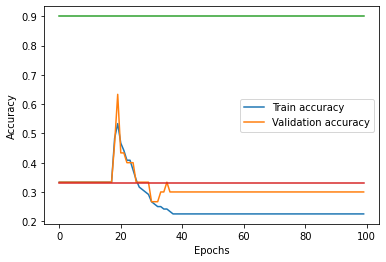

Training accuracy 0.225
Validation accuracy 0.3


In [29]:
model = FFNetwork(num_hidden=1)
model.fit(X_train, y_OH_train,epochs=100, eta=0.5)
print_accuracy()

High bias

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


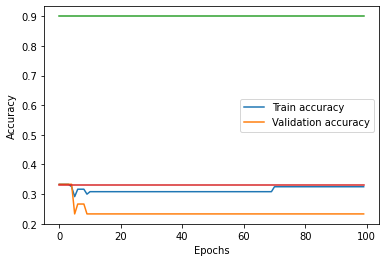

Training accuracy 0.325
Validation accuracy 0.2333


In [30]:
model = FFNetwork(num_hidden=2)
model.fit(X_train, y_OH_train,epochs=100, eta=0.5)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


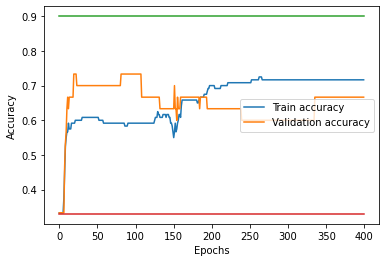

Training accuracy 0.7167
Validation accuracy 0.6667


In [34]:
model = FFNetwork(num_hidden=4)
model.fit(X_train, y_OH_train,epochs=400, eta=0.25, display_loss=False)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


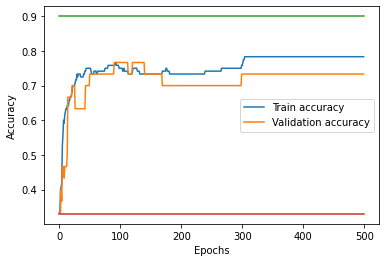

Training accuracy 0.7833
Validation accuracy 0.7333


In [36]:
model = FFNetwork(num_hidden=8)
model.fit(X_train, y_OH_train,epochs=500, eta=0.25, display_loss=False)
print_accuracy()

High variance 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


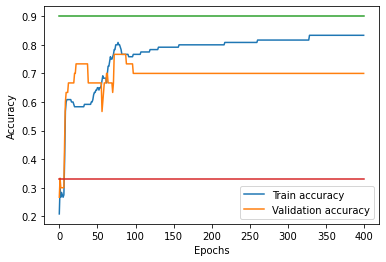

Training accuracy 0.8333
Validation accuracy 0.7


In [37]:
model = FFNetwork(num_hidden=32)
model.fit(X_train, y_OH_train,epochs=400, eta=0.25, display_loss=False)
print_accuracy()

High variance

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


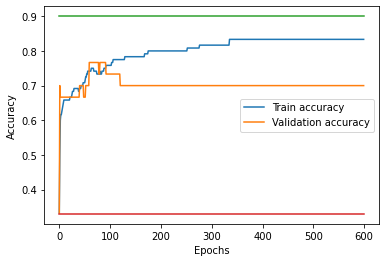

Training accuracy 0.8333
Validation accuracy 0.7


In [39]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train,epochs=600, eta=0.1, display_loss=False)
print_accuracy()

# Add L2 Regularization

model is complex means weights are very large in magnitude

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


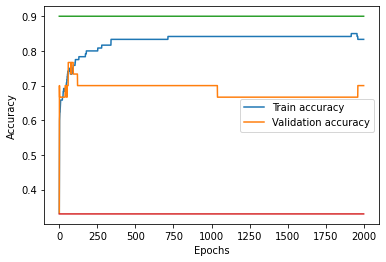

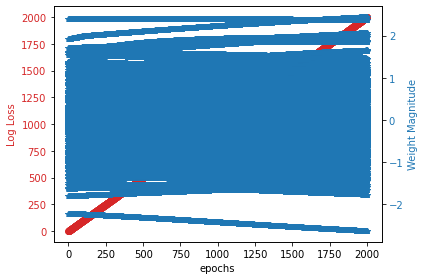

Training accuracy 0.8333
Validation accuracy 0.7


In [59]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=0.1, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


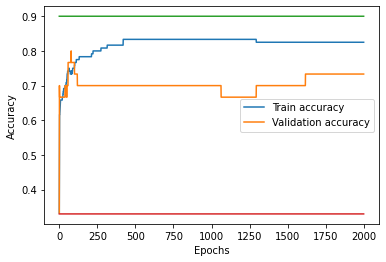

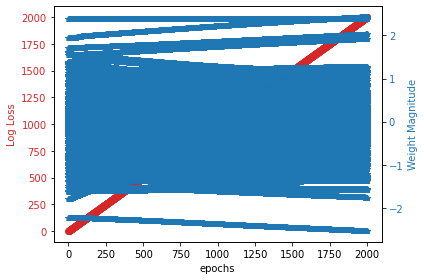

Training accuracy 0.825
Validation accuracy 0.7333


In [55]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=1, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


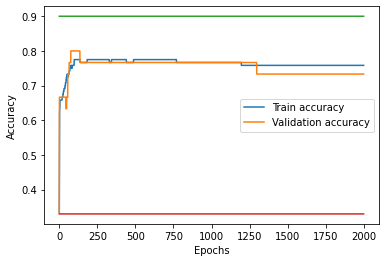

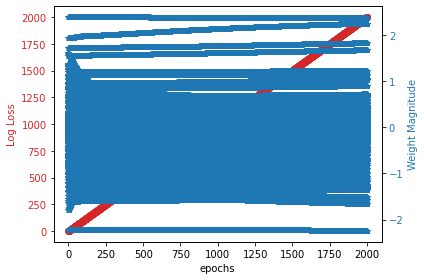

Training accuracy 0.7583
Validation accuracy 0.7333


In [60]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=5, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


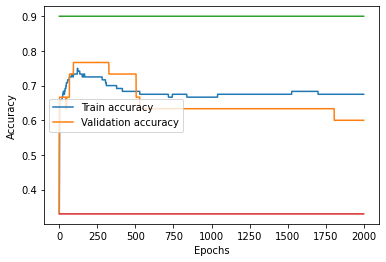

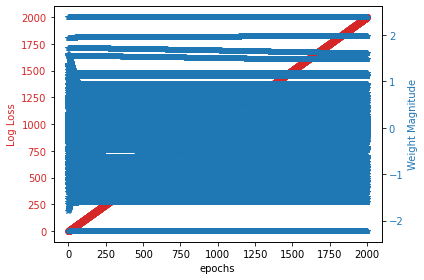

Training accuracy 0.7
Validation accuracy 0.7


In [61]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=10, display_loss=True)
print_accuracy()

# Adding Noise to input Features

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


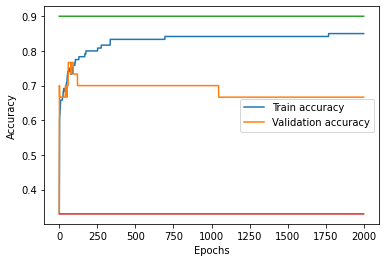

Training accuracy 0.85
Validation accuracy 0.6667


In [62]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=False)
print_accuracy()

0.01


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


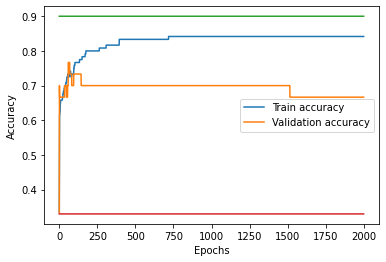

Training accuracy 0.8417
Validation accuracy 0.6667
0.05


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


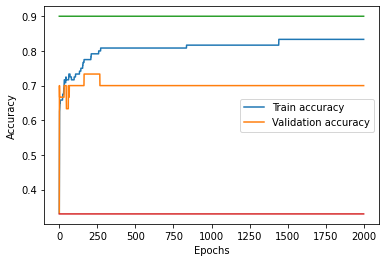

Training accuracy 0.8333
Validation accuracy 0.7
0.1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


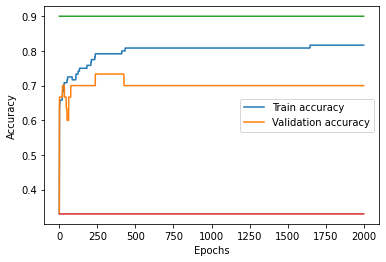

Training accuracy 0.8167
Validation accuracy 0.7
0.15


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


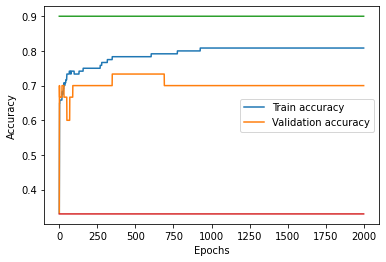

Training accuracy 0.8083
Validation accuracy 0.7
0.18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


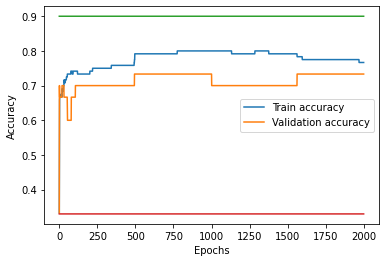

Training accuracy 0.7667
Validation accuracy 0.7333
0.2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


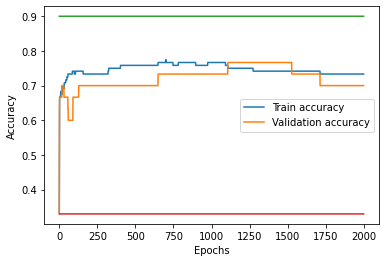

Training accuracy 0.7333
Validation accuracy 0.7


In [63]:
for noise_fraction in [0.01, 0.05, 0.1, 0.15, 0.18, 0.2]:
  print(noise_fraction)
  X_train_noisy = X_train * (1 - noise_fraction*np.random.randn(X_train.shape[0], X_train.shape[1]))
  model = FFNetwork(num_hidden=64)
  model.fit(X_train_noisy, y_OH_train, epochs=2000, eta=0.1, l2_norm=False)
  print_accuracy()

# Early Stopping

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


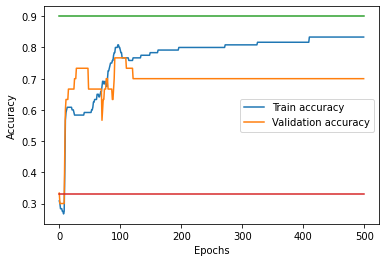

Training accuracy 0.8333
Validation accuracy 0.7


In [66]:
model = FFNetwork(num_hidden=32)
model.fit(X_train, y_OH_train, epochs=500, eta=0.2, display_loss=False)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


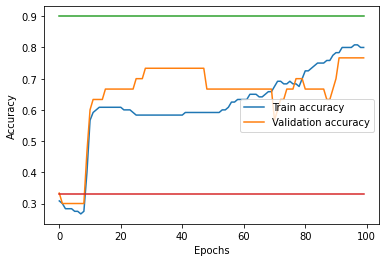

Training accuracy 0.8
Validation accuracy 0.7667


In [69]:
model = FFNetwork(num_hidden=32)
model.fit(X_train, y_OH_train, epochs=100, eta=0.2, display_loss=False)
print_accuracy()